## Summary

In [286]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
import xgboost as xgb
import pickle

from sklearn.metrics import mean_squared_error


In [287]:
# Load train dataset
train = pd.read_csv('../../data/train.csv')
train.head(1)

,zpid,city,street_address,zipcode,description,latitude,longitude,property_tax_rate,garage_spaces,has_association,...,num_of_middle_schools,num_of_high_schools,avg_school_distance,avg_school_rating,avg_school_size,_median_students_per_teacher,num_of_bathrooms,num_of_bedrooms,num_of_stories,home_image
0,111373431,pflugerville,14424 Lake Victor Dr,78660,"14424 Lake Victor Dr, Pflugerville, TX 78660 i...",30.430632,-97.663078,1.98,2,True,...,1,1,1.266667,2.666667,1063,14,3.0,4,2,111373431_ffce26843283d3365c11d81b8e6bdc6f-p_f...


In [288]:
train['avg_school_rating'] = train['avg_school_rating'].map('{:,.2f}'.format).astype('float32')

In [289]:
# Check dataset shape
train.shape

(12900, 47)

In [290]:
features = [
    "city",
    'property_tax_rate',
    'garage_spaces',
    'home_type',
    'year_built',
    'num_of_appliances',
    'num_of_patio_and_porch_features',
    'num_of_security_features',
    'lot_size_sq_ft',
    'living_area_sq_ft',
    'num_of_bedrooms',
    'num_of_bathrooms',
    'num_of_stories',
    "avg_school_rating",
    "num_of_high_schools",
    "latest_salemonth",
]

In [291]:
X = train[features]
X = pd.get_dummies(
    data=X,
    columns=[
        "home_type",
        "city",
        "num_of_stories",
        "num_of_bathrooms",
        "num_of_bedrooms",
        "num_of_security_features",
        "garage_spaces",
        "num_of_high_schools",
        "latest_salemonth",
    ],
)
y = train["latest_price"]
y = np.log(y)

In [294]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

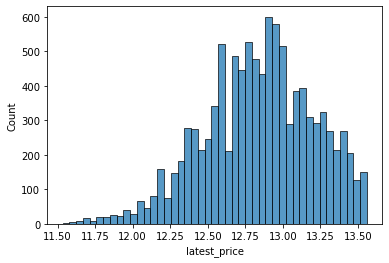

In [295]:
sns.histplot(y_train);

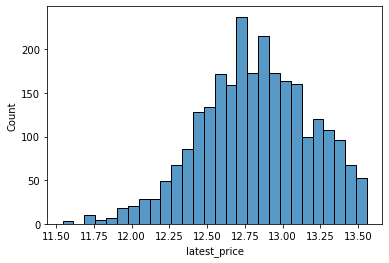

In [296]:
sns.histplot(y_test);

In [297]:
lr = LinearRegression()
# Fit train data
lr.fit(X_train, y_train)
print(
    "Train score : \t",
    lr.score(X_train, y_train),
    "\tTrain RMSE : \t",
    mean_squared_error(
        np.exp(y_train), np.exp(lr.predict(X_train)), squared=False
    ),
)
print(
    "Test score : \t",
    lr.score(X_test, y_test),
    "\tTest RMSE : \t",
    mean_squared_error(
        np.exp(y_test), np.exp(lr.predict(X_test)), squared=False
    ),
)
print("cross_val_score :", cross_val_score(lr, X, y, cv=5).mean())


Train score : 	 0.4569837619717132 	Train RMSE : 	 104795.76094884197
Test score : 	 0.45256053940049323 	Test RMSE : 	 103457.32468475823
cross_val_score : 0.3785905965518467


Text(0, 0.5, 'Predicted SalePrice')

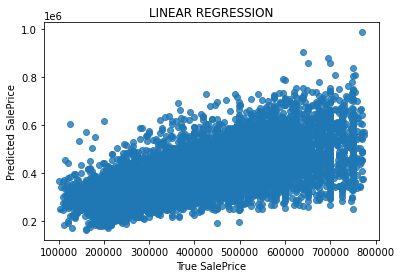

In [298]:
sns.regplot(x=np.exp(y_train), y=np.exp(lr.predict(X_train)));
plt.title('LINEAR REGRESSION')
plt.xlabel('True SalePrice')
plt.ylabel('Predicted SalePrice')

Text(0, 0.5, 'Residuals')

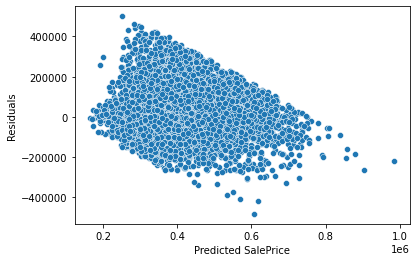

In [299]:
# Plot residuals
y_train_preds = np.exp(lr.predict(X_train))
residuals = np.exp(y_train) - y_train_preds
sns.scatterplot(x=y_train_preds, y=residuals);
plt.xlabel('Predicted SalePrice')
plt.ylabel('Residuals')

## RidgeCV

In [300]:
alphas = np.logspace(0, 5, 100)
ridge_cv = RidgeCV(alphas = alphas, cv=5)
ridge_cv.fit(X_train, y_train)
ridge_cv.alpha_, ridge_cv.best_score_

(3.5938136638046276, 0.4485258432052256)

In [301]:
print(f'Training Score: {ridge_cv.score(X_train, y_train)}', '\tMSE : \t', mean_squared_error(np.exp(y_train), np.exp(ridge_cv.predict(X_train)), squared=False))
print(f'Testing Score: {ridge_cv.score(X_test, y_test)}', '\tMSE : \t', mean_squared_error(np.exp(y_test), np.exp(ridge_cv.predict(X_test)), squared=False))
print('cross_val_score :', cross_val_score(ridge_cv, X, y, cv=5).mean())

Training Score: 0.4563041309632937 	MSE : 	 104844.2270731578
Testing Score: 0.4525798986073113 	MSE : 	 103418.1898318964
cross_val_score : 0.3854070766983897


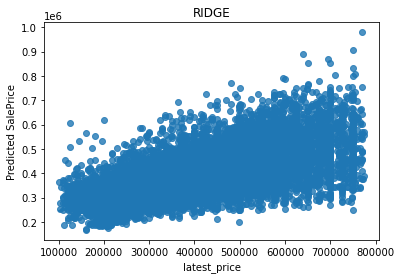

In [302]:
sns.regplot(x=np.exp(y), y=np.exp(ridge_cv.predict(X)));
plt.title('RIDGE')
plt.ylabel('Predicted SalePrice');

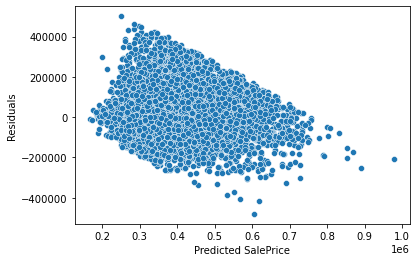

In [303]:
# Plot residuals
y_train_preds = np.exp(ridge_cv.predict(X_train))
residuals = np.exp(y_train) - y_train_preds
sns.scatterplot(x=y_train_preds, y=residuals);
plt.xlabel('Predicted SalePrice')
plt.ylabel('Residuals');

## Lasso

In [304]:
l_alphas = np.logspace(-3, 0, 100)
lasso_cv = LassoCV(alphas = l_alphas, tol=0.05) # increase tol=0.05 to prevent warning
lasso_cv.fit(X_train, y_train)
print('Train score : \t',lasso_cv.score(X_train, y_train), '\tRMSE : \t', mean_squared_error(np.exp(y_train), np.exp(lasso_cv.predict(X_train)), squared=False))
print('Test score : \t',lasso_cv.score(X_test, y_test),  '\tRMSE : \t', mean_squared_error(np.exp(y_test), np.exp(lasso_cv.predict(X_test)), squared=False))
print('cross_val_score :', cross_val_score(lasso_cv, X, y, cv=5).mean())

Train score : 	 0.4446175899479583 	RMSE : 	 105914.18711304823
Test score : 	 0.44338011382532905 	RMSE : 	 104338.52416270322
cross_val_score : 0.37217773631909423


Text(0, 0.5, 'Predicted SalePrice')

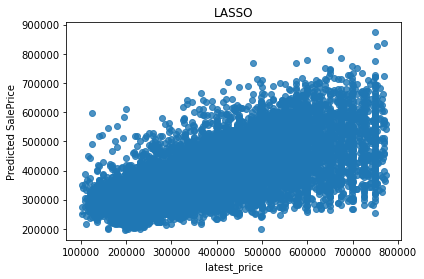

In [305]:
sns.regplot(x=np.exp(y), y=np.exp(lasso_cv.predict(X)));
plt.title('LASSO')
plt.ylabel('Predicted SalePrice')

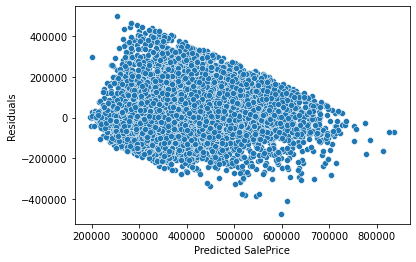

In [306]:

# Plot residuals
y_train_preds = np.exp(lasso_cv.predict(X_train))
residuals = np.exp(y_train) - y_train_preds
sns.scatterplot(x=y_train_preds, y=residuals);
plt.xlabel('Predicted SalePrice')
plt.ylabel('Residuals');

## XGBoost

In [307]:
regressor = xgb.XGBRegressor(
    n_estimators=1000,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)

regressor.fit(X_train, y_train)

print('Train score : \t',regressor.score(X_train, y_train), '\tRMSE : \t', mean_squared_error(np.exp(y_train), np.exp(regressor.predict(X_train)), squared=False))
print('Test score : \t',regressor.score(X_test, y_test),  '\tRMSE : \t', mean_squared_error(np.exp(y_test), np.exp(regressor.predict(X_test)), squared=False))
print('cross_val_score :', cross_val_score(regressor, X, y, cv=5).mean())

Train score : 	 0.8200606304825298 	RMSE : 	 59587.824977567965
Test score : 	 0.5490092188797657 	RMSE : 	 91570.35996412643
cross_val_score : 0.4390209585604783


In [308]:
file_name = "../../streamlit/models/xgb_reg.pkl"

# save
pickle.dump(regressor, open(file_name, "wb"))

In [309]:
train[features].head(1)

,city,property_tax_rate,garage_spaces,home_type,year_built,num_of_appliances,num_of_patio_and_porch_features,num_of_security_features,lot_size_sq_ft,living_area_sq_ft,num_of_bedrooms,num_of_bathrooms,num_of_stories,avg_school_rating,num_of_high_schools,latest_salemonth
0,pflugerville,1.98,2,Single Family,2012,5,1,3,6011.0,2601.0,4,3.0,2,2.67,1,9
